In [1]:
from planet4 import io, region_data, markings
from p4_tools import get_final_markings_counts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import root, curve_fit, leastsq
import pdb
import shapely.geometry as shp
import fiona as fio
from shapely import affinity
from shapely.ops import cascaded_union, unary_union
import time

In [2]:
# read out metadata for season 2 and 3
s2_meta = pd.read_csv('ithaca_season2_metadata.csv')
s3_meta = pd.read_csv('ithaca_season3_metadata.csv')

# read out actual markings for fans and blotches, both seasons combined
fans = pd.read_csv('ithaca_fans.csv')
blotches = pd.read_csv('ithaca_blotches.csv')

# read out tile coordinate data
tiles = pd.read_csv('ithaca_tile_coords.csv')

In [3]:
# find unique obsids in the fans and blotches catalogs
fimg_names = fans.image_name.unique()
bimg_names = blotches.image_name.unique()
fimg_id = fans.image_id.unique()
bimg_id = blotches.image_id.unique()

# add columns for tile position, fill from tile coordinate data
fans['tile_lat'] = 0
fans['tile_lon'] = 0
blotches['tile_lat'] = 0
blotches['tile_lon'] = 0
for i in range(len(fimg_id)):
    fans.tile_lat[fans.image_id==fimg_id[i]] = float(tiles.PlanetocentricLatitude[tiles.image_id==fimg_id[i]])
    fans.tile_lon[fans.image_id==fimg_id[i]] = float(tiles.PositiveEast360Longitude[tiles.image_id==fimg_id[i]])
for i in range(len(bimg_id)):
    blotches.tile_lat[blotches.image_id==bimg_id[i]] = float(tiles.PlanetocentricLatitude[tiles.image_id==bimg_id[i]])
    blotches.tile_lon[blotches.image_id==bimg_id[i]] = float(tiles.PositiveEast360Longitude[tiles.image_id==bimg_id[i]])
    
# add column for season flag and validity of marking
fans['season'] = 0
fans['valid_marking'] = True
blotches['season'] = 0
blotches['valid_marking'] = True
blotches['area'] = np.pi * blotches.radius_1 * blotches.radius_2 / 4

# define column for season flag
fans.season[fans.obsid.str[5] == '1'] = 2
fans.season[fans.obsid.str[5] == '2'] = 3
blotches.season[blotches.obsid.str[5] == '1'] = 2
blotches.season[blotches.obsid.str[5] == '2'] = 3

/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.

In [4]:
# find what size fans should be removed for fair comparison
min_fan_pixels = fans.distance.min()
min_bl_area = blotches.area.min()

max_scale = np.max( (s2_meta.map_scale.max(), s3_meta.map_scale.max() ) )
print('maximum map_scale:',  max_scale, '; min_fan_marking:', min_fan_pixels, '; min_bl_area:', min_bl_area)

# if the minimal fan marking tool is = 10 pixels at max_bin = 4, it will correspond to  
# min_fan_pixels * max_binning / image_binning
s2_meta['min_fan'] = min_fan_pixels * s2_meta.map_scale.max() // s2_meta.map_scale + 1
s3_meta['min_fan'] = min_fan_pixels * s3_meta.map_scale.max() // s3_meta.map_scale + 1

# if the minimal blotch marking tool is = 80 sq. pixels at max_bin = 4, it will correspond to  
# min_bl_area * max_binning^2 / image_binning^2
s2_meta['min_bl'] = min_bl_area * s2_meta.map_scale.max()**2 // s2_meta.map_scale**2 + 1
s3_meta['min_bl'] = min_bl_area * s3_meta.map_scale.max()**2 // s3_meta.map_scale**2 + 1


maximum map_scale: 1.0 ; min_fan_marking: 10.0 ; min_bl_area: 78.5398163397


In [5]:
# mark "valid_marking" key to be False for blotch markings smaller than min_bl for that image
print(len(blotches))
for i in range(len(blotches)):
    if (blotches.season[i] == 2): 
        nr_image =  np.where(s2_meta.obsid == blotches.obsid[i])[0][0]        
        min_b = s2_meta.min_bl[ nr_image  ]         
        if (blotches.area[i] < min_b ):
            blotches.valid_marking[i] = False
    if (blotches.season[i] == 3): 
        nr_image =  np.where(s3_meta.obsid == blotches.obsid[i])[0][0]        
        min_bl = s3_meta.min_bl[ nr_image  ]         
        if (blotches.area[i] < min_b ):
            blotches.valid_marking[i] = False
            
# mark "valid_marking" key to be False for fan markings smaller than min_fan for that image
for i in range(len(fans)):
    if (fans.season[i] == 2): 
        nr_image =  np.where(s2_meta.obsid == fans.obsid[i])[0][0]        
        min_f = s2_meta.min_fan[ nr_image  ]         
        if (fans.distance[i] < min_f ):
            fans.valid_marking[i] = False
    if (fans.season[i] == 3): 
        nr_image =  np.where(s3_meta.obsid == fans.obsid[i])[0][0]        
        min_f = s3_meta.min_fan[ nr_image  ]         
        if (fans.distance[i] < min_f ):
            fans.valid_marking[i] = False

/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


18045


/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chha0593/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
# put all objects together in one df, put all metadata in one df
objects = pd.DataFrame({'name':pd.concat((fans.image_name[fans.valid_marking==True],blotches.image_name[blotches.valid_marking==True])),'type':np.zeros(len(fans.valid_marking[fans.valid_marking==True])+len(blotches.valid_marking[blotches.valid_marking==True])),'long':pd.concat((fans.distance[fans.valid_marking==True],blotches.radius_1[blotches.valid_marking==True])),'short':pd.concat((fans.spread[fans.valid_marking==True],blotches.radius_2[blotches.valid_marking==True])),'x':pd.concat((fans.image_x[fans.valid_marking==True],blotches.image_x[blotches.valid_marking==True])),'y':pd.concat((fans.image_y[fans.valid_marking==True],blotches.image_y[blotches.valid_marking==True])),'angle':pd.concat((fans.angle[fans.valid_marking==True],blotches.angle[blotches.valid_marking==True])),'binning':np.zeros(len(fans.valid_marking[fans.valid_marking==True])+len(blotches.valid_marking[blotches.valid_marking==True])),'l_s':np.zeros(len(fans.valid_marking[fans.valid_marking==True])+len(blotches.valid_marking[blotches.valid_marking==True])),'x_angle':pd.concat((fans.x_angle[fans.valid_marking==True],blotches.x_angle[blotches.valid_marking==True])),'y_angle':pd.concat((fans.y_angle[fans.valid_marking==True],blotches.y_angle[blotches.valid_marking==True])),'tile_lat':pd.concat((fans.tile_lat[fans.valid_marking==True],blotches.tile_lat[blotches.valid_marking==True])),'tile_lon':pd.concat((fans.tile_lon[fans.valid_marking==True],blotches.tile_lon[blotches.valid_marking==True]))}).reset_index(drop=True)
img_unique = objects.name.unique()
meta = pd.concat((s2_meta,s3_meta)).reset_index(drop=True)

# add columns for coverage and season, fill in season
meta['coverage'] = 0
meta['coverage_redundant'] = 0
meta['season'] = 0
meta.iloc[:len(s2_meta),13] = 2
meta.iloc[len(s2_meta):,13] = 3

#add column for binning, l_s, and type of object
for k in range(img_unique.size):
    objects.iloc[np.where(objects.name==img_unique[k])[0],2] = np.asarray(meta.iloc[np.where(meta.obsid==img_unique[k])[0],2])
    objects.iloc[np.where(objects.name==img_unique[k])[0],1] = np.asarray(meta.iloc[np.where(meta.obsid==img_unique[k])[0],0])
    objects.loc[:len(fans.valid_marking[fans.valid_marking==True]),'type'] = 'f'
    objects.loc[len(fans.valid_marking[fans.valid_marking==True]):,'type'] = 'b'

#re-sort objects according to image, so that blotches and fans for the same image won't be split up
objects = objects.sort_values(by='name').reset_index(drop=True)
meta = meta.sort_values(by='obsid').reset_index(drop=True)

In [28]:
# defining HiRise images as shapely polygons
bounds = np.zeros((len(img_unique),4))
points = [None] * 4
img_shapes = [None] * len(img_unique)
plt.figure(1)
for i in range(len(img_unique)):
    # find the corners of each HiRise image based on min and max tile positions
    bounds[i,0] = max(objects.tile_lat[objects.name==img_unique[i]])
    bounds[i,1] = max(objects.tile_lon[objects.name==img_unique[i]])
    bounds[i,2] = min(objects.tile_lat[objects.name==img_unique[i]])
    bounds[i,3] = min(objects.tile_lon[objects.name==img_unique[i]])
    # define corners as points
    points[0] = (bounds[i,0],bounds[i,1])
    points[1] = (bounds[i,2],bounds[i,1])
    points[2] = (bounds[i,2],bounds[i,3])
    points[3] = (bounds[i,0],bounds[i,3])
    # make a polygon out of the points, represents a HiRise image
    img_shapes[i] = shp.Polygon(points[:])
    # get coordinates of exterior of each polygon, plot as an example (visible after next cell)
    x,y = img_shapes[i].exterior.xy
    plt.plot(x,y)

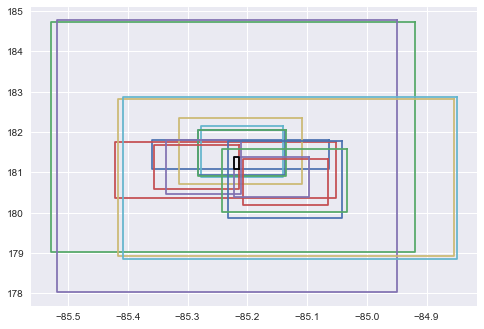

In [29]:
# find most overlapped area - if all polygons in 'img_shapes' intersect, this could be done in a loop,
# but in this case, one of the polygons does not intersect some others, so that one was selected by inspection
# and manually left out. The next line defines the object that is the intersection of all included HiRise images
inter = img_shapes[0].intersection(img_shapes[1]).intersection(img_shapes[2]).intersection(img_shapes[3]).intersection(img_shapes[4]).intersection(img_shapes[5]).intersection(img_shapes[6]).intersection(img_shapes[7]).intersection(img_shapes[8]).intersection(img_shapes[9]).intersection(img_shapes[10]).intersection(img_shapes[11]).intersection(img_shapes[12]).intersection(img_shapes[13]).intersection(img_shapes[15])
# get the coordinates of the exterior of this polygon, plot in black on example plot from last cell
xi,yi = inter.exterior.xy
plt.plot(xi,yi,'k')
plt.show()

NOTE : in the plot above, the rectangle to the right of the black box is the image that does not intersect all the others. it should be red. its index in 'img_shapes' is 14 and it is left out of the calculation of 'inter', but it still has tiles and objects included in 'overlap_objs' because of the buffer

In [23]:
# buffer is the error margin surrounding 'inter' - make it bigger to allow tiles farther from the exterior of 'inter' 
# to be included. it is set to a number that allows some tiles from all images to be included
buffer = 0.0005
# next 4 lines define the corners of 'inter' (with buffering) for filtering
lo_lat = xi[2] * (1. + buffer)
hi_lat = xi[0] * (1. - buffer)
lo_lon = yi[0] * (1. - buffer)
hi_lon = yi[2] * (1. + buffer)

In [24]:
# filter 'objects' so that only markings in tiles whose centers are within boundaries in cell above are left in
overlap_objs = objects.loc[(objects['tile_lat'] > lo_lat) & (objects['tile_lon'] < hi_lon) & (objects['tile_lat'] < hi_lat) & (objects['tile_lon'] > lo_lon)]
ol_img_unique = overlap_objs.name.unique()

In [25]:
# create space for data to be plotted
n_marks = np.zeros((len(ol_img_unique),5))
img_fans = np.zeros((len(ol_img_unique),overlap_objs.name.value_counts()[0]))
img_blotches = np.zeros((len(ol_img_unique),overlap_objs.name.value_counts()[0]))
f_histmax = np.zeros((len(ol_img_unique)))
b_histmax = np.zeros((len(ol_img_unique)))
for i in range(len(ol_img_unique)):
    # record number of fans, then blotches for each image
    n_marks[i,0] = overlap_objs.name[(overlap_objs.type=='f') & (overlap_objs.name==ol_img_unique[i])].value_counts()[0]
    n_marks[i,1] = overlap_objs.name[(overlap_objs.type=='b') & (overlap_objs.name==ol_img_unique[i])].value_counts()[0]
    # record l_s for each image to make plotting simpler
    n_marks[i,2] = meta.l_s[meta.obsid==ol_img_unique[i]]
    # record number of fans, then blotches for each image divided by the number of tiles from that image included in 'overlap_objs'
    n_marks[i,3] = n_marks[i,0]//len(overlap_objs.tile_lat[(overlap_objs.name==ol_img_unique[i]) & (overlap_objs.type=='f')].value_counts())
    n_marks[i,4] = n_marks[i,1]//len(overlap_objs.tile_lat[(overlap_objs.name==ol_img_unique[i]) & (overlap_objs.type=='b')].value_counts())
    # put fan lengths (*binning), then blotch areas (*binning) in array organized by image
    img_fans[i,:overlap_objs.name[(overlap_objs.name==ol_img_unique[i]) & (overlap_objs.type=='f')].value_counts()[0]] = overlap_objs.long[(overlap_objs.name==ol_img_unique[i]) & (overlap_objs.type=='f')] * overlap_objs.binning[(overlap_objs.name==ol_img_unique[i]) & (overlap_objs.type=='f')]
    img_blotches[i,:overlap_objs.name[(overlap_objs.name==ol_img_unique[i]) & (overlap_objs.type=='b')].value_counts()[0]] = overlap_objs.long[(overlap_objs.name==ol_img_unique[i]) & (overlap_objs.type=='b')] * overlap_objs.short[(overlap_objs.name==ol_img_unique[i]) & (overlap_objs.type=='b')] * overlap_objs.binning[(overlap_objs.name==ol_img_unique[i]) & (overlap_objs.type=='b')] * np.pi
    # find fan length, then blotch area corresponding to hist max, record that
    f_hist,f_binedges = np.histogram(img_fans[i,np.where(img_fans[i,:]>0.0)],bins=50)
    f_histmax[i] = f_binedges[np.where(f_hist==f_hist.max())[0][0]]
    b_hist,b_binedges = np.histogram(img_blotches[i,np.where(img_blotches[i,:]>0.0)],bins=50)
    b_histmax[i] = b_binedges[np.where(b_hist==b_hist.max())[0][0]]

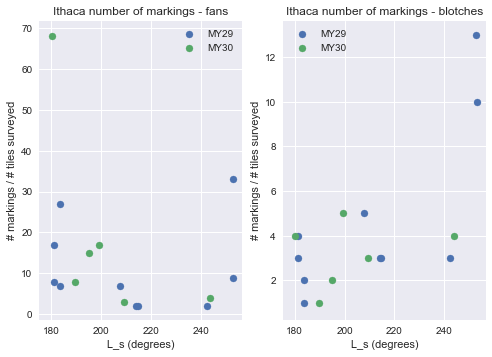

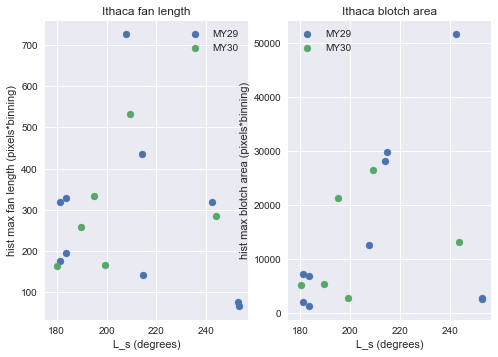

In [26]:
# plot data
plt.figure(2)
plt.subplot(121)
plt.scatter(n_marks[:len(s2_meta),2],n_marks[:len(s2_meta),3],label='MY29')
plt.scatter(n_marks[len(s2_meta):,2],n_marks[len(s2_meta):,3],label='MY30')
plt.legend()
plt.title('Ithaca number of markings - fans')
plt.xlabel('L_s (degrees)')
plt.ylabel('# markings / # tiles surveyed')
plt.subplot(122)
plt.scatter(n_marks[:len(s2_meta),2],n_marks[:len(s2_meta),4],label='MY29')
plt.scatter(n_marks[len(s2_meta):,2],n_marks[len(s2_meta):,4],label='MY30')
plt.legend()
plt.title('Ithaca number of markings - blotches')
plt.xlabel('L_s (degrees)')
plt.ylabel('# markings / # tiles surveyed')
plt.figure(3)
plt.subplot(121)
plt.scatter(n_marks[:len(s2_meta),2],f_histmax[:len(s2_meta)],label='MY29')
plt.scatter(n_marks[len(s2_meta):,2],f_histmax[len(s2_meta):],label='MY30')
plt.legend()
plt.title('Ithaca fan length')
plt.xlabel('L_s (degrees)')
plt.ylabel('hist max fan length (pixels*binning)')
plt.subplot(122)
plt.scatter(n_marks[:len(s2_meta),2],b_histmax[:len(s2_meta)],label='MY29')
plt.scatter(n_marks[len(s2_meta):,2],b_histmax[len(s2_meta):],label='MY30')
plt.legend()
plt.title('Ithaca blotch area')
plt.xlabel('L_s (degrees)')
plt.ylabel('hist max blotch area (pixels*binning)')
plt.show()